Simplified baseline model removed dueling dqn and beta scheduling from PER

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1: Reward: 34.9
  Completed Tasks: 10, Total Energy: 23.0kJ
  Local Tasks: 5, Edge Tasks: 5
  Action Distribution: [5, 0, 5]
  CPU Energy: 0.0kJ, Epsilon: 0.950
  Initial Mobile Batteries: [60406.2  49124.16 65321.28]
  Initial Edge Batteries: [862444.8 469886.4]
  Final Mobile Batteries: [60402.97900559 49116.457906   65314.94359   ]
  Final Edge Batteries: [862444.8        469880.63754955]
  File Details (per task):
    File 1: Size = 259 MB, Processed at = Mobile device 0, Energy used = 0.81 J
    File 2: Size = 493 MB, Processed at = Mobile device 1, Energy used = 3.91 J
    File 3: Size = 366 MB, Processed at = Edge server 1, Energy used = 2.49 J
    File 4: Size = 457 MB, Processed at = Edge server 1, Energy used = 2.63 J
    File 5: Size = 425 MB, Processed at = Mobile device 2, Energy used = 1.68 J
    File 6: Size = 478 MB, Processed at = Mobile device 1, Energy used = 3.79 J
    File 7: Size = 289 MB, Processed at = Edge server 1, Energy used = 1.97 J
    File 8: Size

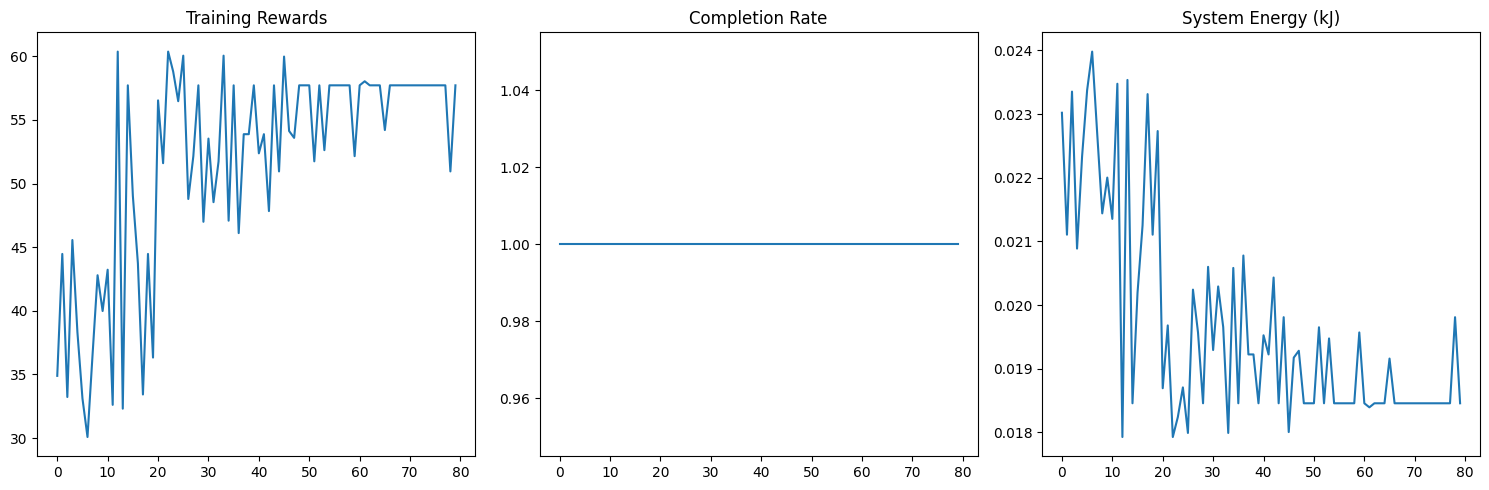

In [18]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100  # Convert to fraction
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class SimplifiedPERBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0  # Initial priority for new transitions

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        return samples, indices

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks

        # Reward parameters
        self.task_reward = 15.0
        self.energy_scale =5.0  # Converts Joules to reward penalty
        self.task_penalty = 20.0

        # Voltage constants
        self.VOLTAGE_MD = 3.7  # 3.7V for mobile devices
        self.VOLTAGE_ES = 12.0  # 12V for edge servers
        self.MAH_TO_J = 3.6  # 1 mAh = 3.6 J at 1V

        # Mobile Devices (Convert all to Joules)
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)  # GHz
        self.md_battery = np.random.randint(3000, 5001, num_md) * self.MAH_TO_J * self.VOLTAGE_MD  # J
        self.md_energy_local = (np.random.uniform(1000, 3000, num_md)/1000) * self.VOLTAGE_MD  # W (J/s)
        self.md_energy_tx = np.random.uniform(0.0001, 0.0003, num_md) * self.MAH_TO_J * self.VOLTAGE_MD  # J/MB

        # Edge Servers
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)  # GHz
        self.es_battery = np.random.randint(10000, 20001, num_es) * self.MAH_TO_J * self.VOLTAGE_ES  # J
        self.es_energy_process = (np.random.uniform(500, 1500, num_es)/1000) * self.VOLTAGE_ES  # W (J/s)

        # Task parameters
        self.task_requirements = np.random.randint(100, 500, num_tasks)  # MB
        self.task_to_md = np.random.randint(0, num_md, num_tasks)

        self.reset()

    def reset(self):
        # Reset batteries with Joules
        self.md_battery = np.random.randint(3000, 5001, self.num_md) * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = np.random.randint(10000, 20001, self.num_es) * self.MAH_TO_J * self.VOLTAGE_ES

        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0  # Total energy in Joules
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(5 + self.num_es*3 + 1)

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]

        # Normalized state values with J-based metrics
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES

        state = [
            self.md_battery[md_idx] / max_md_energy,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / (3.0 * self.VOLTAGE_MD),  # Max 3000mA → 3A * 3.7V = 11.1W
            self.md_energy_tx[md_idx] / (0.0003 * self.MAH_TO_J * self.VOLTAGE_MD)
        ]

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / (1.5 * self.VOLTAGE_ES)  # Max 1500mA → 1.5A * 12V = 18W
            ])

        state.append(self.current_task / self.num_tasks)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros_like(self._get_state()), 0, True, {}

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        done = False
        energy_used = 0
        reward = 0

        # Prepare a dictionary to store details for this file/task.
        file_info = {
            "file_size_MB": task_size,
            "processed_at": None,
            "energy_used_J": 0
        }

        if action == 0:  # Local processing
            self.local_task_count += 1
            processing_time = (task_size * 1e6) / (self.md_compute[md_idx] * 1e9)
            energy_needed = self.md_energy_local[md_idx] * processing_time

            if self.md_battery[md_idx] >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                energy_used = energy_needed
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Mobile device {md_idx}"
        else:  # Offload processing
            self.edge_task_count += 1
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1

            tx_energy = self.md_energy_tx[md_idx] * task_size
            processing_time = (task_size * 1e6) / (self.es_compute[es_idx] * 1e9)
            process_energy = self.es_energy_process[es_idx] * processing_time

            if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1
                energy_used = tx_energy + process_energy
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Edge server {es_idx}"

        file_info["energy_used_J"] = energy_used
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()

        # Include file_info in the info dict for tracking.
        info = {"file_info": file_info}
        return next_state, reward, done, info

class SimplifiedDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = SimplifiedPERBuffer(50000)
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.0005
        self.tau = 0.01
        
        # Standard DQN architecture without dueling
        self.model = self._build_dqn()
        self.target_model = self._build_dqn()
        self.update_target_network()

    def _build_dqn(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', input_shape=(self.state_size,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(self.action_size)
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        
        samples, indices = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        # Train without importance sampling weights
        self.model.fit(states, current_q, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()

def train_agent(episodes=80):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env._get_state())
    agent = SimplifiedDQNAgent(state_size, 1 + env.num_es)

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distribution = []
    episode_details = []  # To store detailed info per episode

    for episode in range(episodes):
        tracker.start()
        # Record initial battery levels (make copies so later changes don't affect these)


        state = env.reset()
        
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)  # Track action distribution
        file_details = []  # To store details for each file processed

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1

            next_state, reward, done, info = env.step(action)
            # Append the file-level details from this step
            file_details.append(info.get("file_info", {}))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay()

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        energy = tracker.stop()

        # Record final battery levels after processing all tasks
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()

        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy)
        action_distribution.append(episode_actions)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,  # list of dicts for each file
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Print summary for the episode including additional details
        print(f"Episode {episode + 1}: Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}, Total Energy: {env.total_energy:.1f}kJ")
        print(f"  Local Tasks: {env.local_task_count}, Edge Tasks: {env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  CPU Energy: {energy['cpu_j']:.1f}kJ, Epsilon: {agent.epsilon:.3f}")
        print("  Initial Mobile Batteries:", initial_md_battery)
        print("  Initial Edge Batteries:", initial_es_battery)
        print("  Final Mobile Batteries:", final_md_battery)
        print("  Final Edge Batteries:", final_es_battery)
        print("  File Details (per task):")
        for idx, detail in enumerate(file_details):
            print(f"    File {idx + 1}: Size = {detail.get('file_size_MB', 'N/A')} MB, Processed at = {detail.get('processed_at', 'N/A')}, Energy used = {detail.get('energy_used_J', 0):.2f} J")
        print()

    # Optionally, plot overall performance graphs for rewards, completion rates, and energy consumption.
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title('Training Rewards')

    plt.subplot(1, 3, 2)
    plt.plot(completion_rates)
    plt.title('Completion Rate')

    plt.subplot(1, 3, 3)
    plt.plot(np.array(energy_consumptions) / 1000)
    plt.title('System Energy (kJ)')

    plt.tight_layout()
    plt.show()

    # You can also return episode_details if further analysis is desired.
    return episode_details

if __name__ == "__main__":
    train_agent()


Improved  model with fixed task size for checking all hyperparameter types

In [ ]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os

# Set global seeds for full reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100  # Convert to fraction
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=50, load_from_file=None):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks

        # Fixed physical parameters
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.task_reward = 15.0
        self.energy_scale = 5.0
        self.task_penalty = 20.0

        if load_from_file:  # Load full state from file
            self._load_state(load_from_file)
        else:  # Initialize new environment
            # Randomly generated parameters
            self.md_compute = np.random.uniform(1.0, 3.0, num_md)
            self.es_compute = np.random.uniform(3.0, 5.0, num_es)
            self.task_requirements = np.random.randint(100, 500, num_tasks)
            self.task_to_md = np.random.randint(0, num_md, num_tasks)
            
            # Energy parameters (derived from random values)
            self.md_energy_local = (np.random.uniform(1000, 3000, num_md)/1000) * self.VOLTAGE_MD
            self.md_energy_tx = np.random.uniform(0.0001, 0.0003, num_md) * self.MAH_TO_J * self.VOLTAGE_MD
            self.es_energy_process = (np.random.uniform(500, 1500, num_es)/1000) * self.VOLTAGE_ES

        self.reset()

    def _load_state(self, filename):
        """Load all environment parameters from file"""
        data = np.load(filename, allow_pickle=True)
        self.md_compute = data['md_compute']
        self.es_compute = data['es_compute']
        self.task_requirements = data['task_requirements']
        self.task_to_md = data['task_to_md']
        self.md_energy_local = data['md_energy_local']
        self.md_energy_tx = data['md_energy_tx']
        self.es_energy_process = data['es_energy_process']

    def save_state(self, filename):
        """Save all environment parameters to file"""
        np.savez(filename,
                 md_compute=self.md_compute,
                 es_compute=self.es_compute,
                 task_requirements=self.task_requirements,
                 task_to_md=self.task_to_md,
                 md_energy_local=self.md_energy_local,
                 md_energy_tx=self.md_energy_tx,
                 es_energy_process=self.es_energy_process)

    def reset(self):
        """Reset dynamic state (batteries and counters)"""
        # Battery initialization (using fixed seed)
        np.random.seed(42)  # Seed for reproducible battery levels
        self.md_battery = np.random.randint(3000, 5001, self.num_md) * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = np.random.randint(10000, 20001, self.num_es) * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Reset counters
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(5 + self.num_es*3 + 1)

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]

        # Normalized state values with J-based metrics
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES

        state = [
            self.md_battery[md_idx] / max_md_energy,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / (3.0 * self.VOLTAGE_MD),  # Max 3000mA → 3A * 3.7V = 11.1W
            self.md_energy_tx[md_idx] / (0.0003 * self.MAH_TO_J * self.VOLTAGE_MD)
        ]

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / (1.5 * self.VOLTAGE_ES)  # Max 1500mA → 1.5A * 12V = 18W
            ])

        state.append(self.current_task / self.num_tasks)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros_like(self._get_state()), 0, True, {}

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        done = False
        energy_used = 0
        reward = 0

        # Prepare a dictionary to store details for this file/task.
        file_info = {
            "file_size_MB": task_size,
            "processed_at": None,
            "energy_used_J": 0
        }

        if action == 0:  # Local processing
            self.local_task_count += 1
            processing_time = (task_size * 1e6) / (self.md_compute[md_idx] * 1e9)
            energy_needed = self.md_energy_local[md_idx] * processing_time

            if self.md_battery[md_idx] >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                energy_used = energy_needed
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Mobile device {md_idx}"
        else:  # Offload processing
            self.edge_task_count += 1
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1

            tx_energy = self.md_energy_tx[md_idx] * task_size
            processing_time = (task_size * 1e6) / (self.es_compute[es_idx] * 1e9)
            process_energy = self.es_energy_process[es_idx] * processing_time

            if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1
                energy_used = tx_energy + process_energy
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Edge server {es_idx}"

        file_info["energy_used_J"] = energy_used
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()

        # Include file_info in the info dict for tracking.
        info = {"file_info": file_info}
        return next_state, reward, done, info

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(50000)
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.0005
        self.tau = 0.01
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()
        self.beta = 0.4
        self.beta_increment = (1.0 - 0.4) / 100000

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        samples, indices, weights = self.memory.sample(self.batch_size, beta=self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        self.beta = min(1.0, self.beta + self.beta_increment)

def train_agent(episodes=80):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env._get_state())
    agent = DQNAgent(state_size, 1 + env.num_es)

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distribution = []
    episode_details = []  # To store detailed info per episode

    for episode in range(episodes):
        tracker.start()
        # Record initial battery levels (make copies so later changes don't affect these)


        state = env.reset()
        
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)  # Track action distribution
        file_details = []  # To store details for each file processed

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1

            next_state, reward, done, info = env.step(action)
            # Append the file-level details from this step
            file_details.append(info.get("file_info", {}))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay()

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        energy = tracker.stop()

        # Record final battery levels after processing all tasks
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()

        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy)
        action_distribution.append(episode_actions)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,  # list of dicts for each file
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Print summary for the episode including additional details
        print(f"Episode {episode + 1}: Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}, Total Energy: {env.total_energy:.1f}kJ")
        print(f"  Local Tasks: {env.local_task_count}, Edge Tasks: {env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  CPU Energy: {energy['cpu_j']:.1f}kJ, Epsilon: {agent.epsilon:.3f}")
        print("  Initial Mobile Batteries:", initial_md_battery)
        print("  Initial Edge Batteries:", initial_es_battery)
        print("  Final Mobile Batteries:", final_md_battery)
        print("  Final Edge Batteries:", final_es_battery)
        print("  File Details (per task):")
        for idx, detail in enumerate(file_details):
            print(f"    File {idx + 1}: Size = {detail.get('file_size_MB', 'N/A')} MB, Processed at = {detail.get('processed_at', 'N/A')}, Energy used = {detail.get('energy_used_J', 0):.2f} J")
        print()

    # Optionally, plot overall performance graphs for rewards, completion rates, and energy consumption.
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title('Training Rewards')

    plt.subplot(1, 3, 2)
    plt.plot(completion_rates)
    plt.title('Completion Rate')

    plt.subplot(1, 3, 3)
    plt.plot(np.array(energy_consumptions) / 1000)
    plt.title('System Energy (kJ)')

    plt.tight_layout()
    plt.show()

    # You can also return episode_details if further analysis is desired.
    return episode_details

if __name__ == "__main__":
    train_agent()

Episode 1: Reward: 328.2
  Completed Tasks: 50, Total Energy: 84.4kJ
  Local Tasks: 17, Edge Tasks: 33
  Action Distribution: [17, 16, 17]
  CPU Energy: 0.0kJ, Epsilon: 0.950
  Initial Mobile Batteries: [54958.32 59393.88 51415.2 ]
  Initial Edge Batteries: [664848.  656251.2]
  Final Mobile Batteries: [54939.45540235 59371.45536041 51396.65583472]
  Final Edge Batteries: [664836.38486738 656238.29743543]
  File Details (per task):
    File 1: Size = 314 MB, Processed at = Edge server 1, Energy used = 1.81 J
    File 2: Size = 430 MB, Processed at = Edge server 1, Energy used = 2.47 J
    File 3: Size = 187 MB, Processed at = Mobile device 0, Energy used = 1.02 J
    File 4: Size = 472 MB, Processed at = Edge server 1, Energy used = 2.72 J
    File 5: Size = 199 MB, Processed at = Edge server 0, Energy used = 1.26 J
    File 6: Size = 459 MB, Processed at = Edge server 0, Energy used = 2.98 J
    File 7: Size = 251 MB, Processed at = Mobile device 0, Energy used = 1.37 J
    File 8: Si

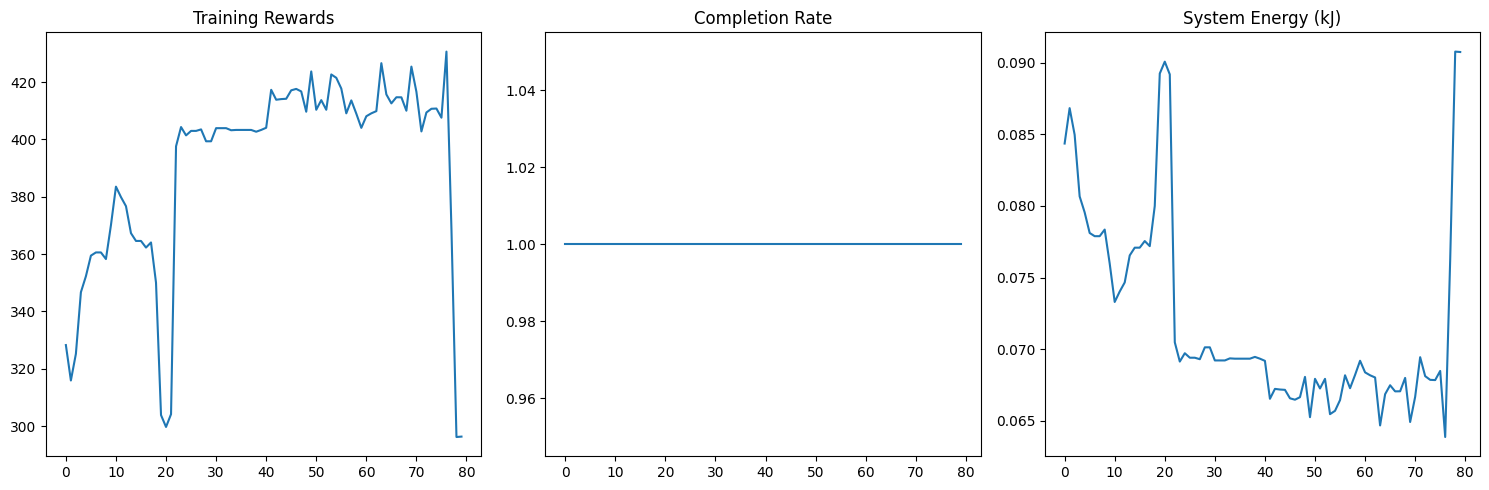

In [19]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os

# Set global seeds for full reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100  # Convert to fraction
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=50, load_from_file=None):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks

        # Fixed physical parameters
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.task_reward = 15.0
        self.energy_scale = 5.0
        self.task_penalty = 20.0

        if load_from_file:  # Load full state from file
            self._load_state(load_from_file)
        else:  # Initialize new environment
            # Randomly generated parameters
            self.md_compute = np.random.uniform(1.0, 3.0, num_md)
            self.es_compute = np.random.uniform(3.0, 5.0, num_es)
            self.task_requirements = np.random.randint(100, 500, num_tasks)
            self.task_to_md = np.random.randint(0, num_md, num_tasks)
            
            # Energy parameters (derived from random values)
            self.md_energy_local = (np.random.uniform(1000, 3000, num_md)/1000) * self.VOLTAGE_MD
            self.md_energy_tx = np.random.uniform(0.0001, 0.0003, num_md) * self.MAH_TO_J * self.VOLTAGE_MD
            self.es_energy_process = (np.random.uniform(500, 1500, num_es)/1000) * self.VOLTAGE_ES

        self.reset()

    def _load_state(self, filename):
        """Load all environment parameters from file"""
        data = np.load(filename, allow_pickle=True)
        self.md_compute = data['md_compute']
        self.es_compute = data['es_compute']
        self.task_requirements = data['task_requirements']
        self.task_to_md = data['task_to_md']
        self.md_energy_local = data['md_energy_local']
        self.md_energy_tx = data['md_energy_tx']
        self.es_energy_process = data['es_energy_process']

    def save_state(self, filename):
        """Save all environment parameters to file"""
        np.savez(filename,
                 md_compute=self.md_compute,
                 es_compute=self.es_compute,
                 task_requirements=self.task_requirements,
                 task_to_md=self.task_to_md,
                 md_energy_local=self.md_energy_local,
                 md_energy_tx=self.md_energy_tx,
                 es_energy_process=self.es_energy_process)

    def reset(self):
        """Reset dynamic state (batteries and counters)"""
        # Battery initialization (using fixed seed)
        np.random.seed(42)  # Seed for reproducible battery levels
        self.md_battery = np.random.randint(3000, 5001, self.num_md) * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = np.random.randint(10000, 20001, self.num_es) * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Reset counters
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(5 + self.num_es*3 + 1)

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]

        # Normalized state values with J-based metrics
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES

        state = [
            self.md_battery[md_idx] / max_md_energy,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / (3.0 * self.VOLTAGE_MD),  # Max 3000mA → 3A * 3.7V = 11.1W
            self.md_energy_tx[md_idx] / (0.0003 * self.MAH_TO_J * self.VOLTAGE_MD)
        ]

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / (1.5 * self.VOLTAGE_ES)  # Max 1500mA → 1.5A * 12V = 18W
            ])

        state.append(self.current_task / self.num_tasks)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros_like(self._get_state()), 0, True, {}

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        done = False
        energy_used = 0
        reward = 0

        # Prepare a dictionary to store details for this file/task.
        file_info = {
            "file_size_MB": task_size,
            "processed_at": None,
            "energy_used_J": 0
        }

        if action == 0:  # Local processing
            self.local_task_count += 1
            processing_time = (task_size * 1e6) / (self.md_compute[md_idx] * 1e9)
            energy_needed = self.md_energy_local[md_idx] * processing_time

            if self.md_battery[md_idx] >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                energy_used = energy_needed
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Mobile device {md_idx}"
        else:  # Offload processing
            self.edge_task_count += 1
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1

            tx_energy = self.md_energy_tx[md_idx] * task_size
            processing_time = (task_size * 1e6) / (self.es_compute[es_idx] * 1e9)
            process_energy = self.es_energy_process[es_idx] * processing_time

            if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1
                energy_used = tx_energy + process_energy
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Edge server {es_idx}"

        file_info["energy_used_J"] = energy_used
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()

        # Include file_info in the info dict for tracking.
        info = {"file_info": file_info}
        return next_state, reward, done, info

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(50000)
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.0005
        self.tau = 0.01
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()
        self.beta = 0.4
        self.beta_increment = (1.0 - 0.4) / 100000

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        samples, indices, weights = self.memory.sample(self.batch_size, beta=self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        self.beta = min(1.0, self.beta + self.beta_increment)

def train_agent(episodes=80):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env._get_state())
    agent = DQNAgent(state_size, 1 + env.num_es)

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distribution = []
    episode_details = []  # To store detailed info per episode

    for episode in range(episodes):
        tracker.start()
        # Record initial battery levels (make copies so later changes don't affect these)


        state = env.reset()
        
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)  # Track action distribution
        file_details = []  # To store details for each file processed

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1

            next_state, reward, done, info = env.step(action)
            # Append the file-level details from this step
            file_details.append(info.get("file_info", {}))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay()

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        energy = tracker.stop()

        # Record final battery levels after processing all tasks
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()

        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy)
        action_distribution.append(episode_actions)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,  # list of dicts for each file
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Print summary for the episode including additional details
        print(f"Episode {episode + 1}: Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}, Total Energy: {env.total_energy:.1f}kJ")
        print(f"  Local Tasks: {env.local_task_count}, Edge Tasks: {env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  CPU Energy: {energy['cpu_j']:.1f}kJ, Epsilon: {agent.epsilon:.3f}")
        print("  Initial Mobile Batteries:", initial_md_battery)
        print("  Initial Edge Batteries:", initial_es_battery)
        print("  Final Mobile Batteries:", final_md_battery)
        print("  Final Edge Batteries:", final_es_battery)
        print("  File Details (per task):")
        for idx, detail in enumerate(file_details):
            print(f"    File {idx + 1}: Size = {detail.get('file_size_MB', 'N/A')} MB, Processed at = {detail.get('processed_at', 'N/A')}, Energy used = {detail.get('energy_used_J', 0):.2f} J")
        print()

    # Optionally, plot overall performance graphs for rewards, completion rates, and energy consumption.
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title('Training Rewards')

    plt.subplot(1, 3, 2)
    plt.plot(completion_rates)
    plt.title('Completion Rate')

    plt.subplot(1, 3, 3)
    plt.plot(np.array(energy_consumptions) / 1000)
    plt.title('System Energy (kJ)')

    plt.tight_layout()
    plt.show()

    # You can also return episode_details if further analysis is desired.
    return episode_details

if __name__ == "__main__":
    train_agent()

Main Model with hyperparameter tuning


=== Running hyperparam set: A ===
Tasks (MB): [413 121 352 335 444 148 158 269 287 370]
Task → MD mapping: [1 1 2 1 2 2 0 2 0 2]
Episode 1/50: Reward=-40.05, Completed=10, Energy=14.01J, Epsilon=0.990
Episode 2/50: Reward=-12.00, Completed=10, Energy=11.20J, Epsilon=0.980
Episode 3/50: Reward=-7.55, Completed=10, Energy=10.76J, Epsilon=0.970
Episode 4/50: Reward=-18.90, Completed=10, Energy=11.89J, Epsilon=0.961
Episode 5/50: Reward=-23.15, Completed=10, Energy=12.32J, Epsilon=0.951
Episode 6/50: Reward=-8.84, Completed=10, Energy=10.88J, Epsilon=0.941
Episode 7/50: Reward=-29.10, Completed=10, Energy=12.91J, Epsilon=0.932
Episode 8/50: Reward=-2.66, Completed=10, Energy=10.27J, Epsilon=0.923
Episode 9/50: Reward=-0.97, Completed=10, Energy=10.10J, Epsilon=0.914
Episode 10/50: Reward=-7.68, Completed=10, Energy=10.77J, Epsilon=0.904
Episode 11/50: Reward=-9.75, Completed=10, Energy=10.98J, Epsilon=0.895
Episode 12/50: Reward=-4.56, Completed=10, Energy=10.46J, Epsilon=0.886
Episode 13

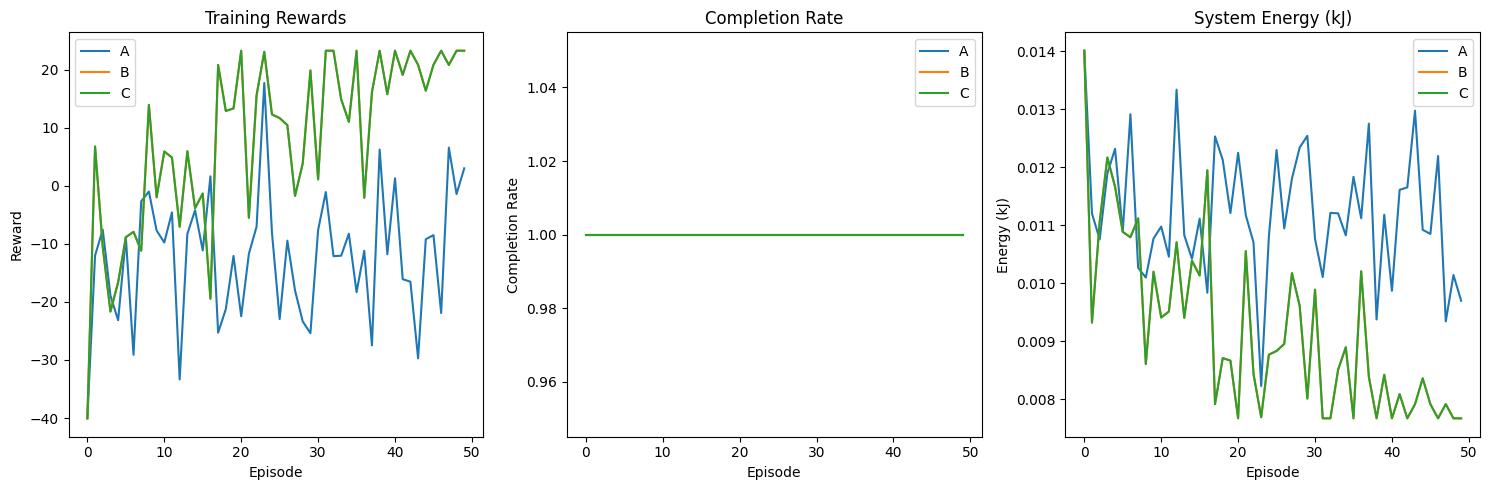

In [5]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

#############################
# Energy Tracker (unchanged)
#############################
class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100  # Convert to fraction
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

##########################################
# Prioritized Replay Buffer (unchanged)
##########################################
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

##################################
# MEC Environment (slightly modified)
##################################
class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks

        # Reward parameters
        self.task_reward = 10.0
        self.energy_scale = 10  # Default Joules-to-reward penalty
        self.task_penalty = 20.0

        # Voltage constants
        self.VOLTAGE_MD = 3.7  # 3.7V for mobile devices
        self.VOLTAGE_ES = 12.0  # 12V for edge servers
        self.MAH_TO_J = 3.6     # 1 mAh = 3.6 J at 1V

        # Mobile Devices (Convert all to Joules)
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)  # GHz
        self.md_battery = np.random.randint(3000, 5001, num_md) * self.MAH_TO_J * self.VOLTAGE_MD
        self.md_energy_local = (np.random.uniform(1000, 3000, num_md)/1000) * self.VOLTAGE_MD  # W (J/s)
        self.md_energy_tx = np.random.uniform(0.0001, 0.0003, num_md) * self.MAH_TO_J * self.VOLTAGE_MD  # J/MB

        # Edge Servers
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)  # GHz
        self.es_battery = np.random.randint(10000, 20001, num_es) * self.MAH_TO_J * self.VOLTAGE_ES
        self.es_energy_process = (np.random.uniform(500, 1500, num_es)/1000) * self.VOLTAGE_ES  # W (J/s)

        # Task parameters
        self.task_requirements = np.random.randint(100, 500, num_tasks)  # MB
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        
        print("Tasks (MB):", self.task_requirements)
        print("Task → MD mapping:", self.task_to_md)


        self.reset()

    def reset(self):
        # Reset batteries with Joules
        self.md_battery = np.random.randint(3000, 5001, self.num_md) * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = np.random.randint(10000, 20001, self.num_es) * self.MAH_TO_J * self.VOLTAGE_ES

        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0  # Total energy in Joules
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(5 + self.num_es*3 + 1)

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]

        # Normalized state values
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES

        state = [
            self.md_battery[md_idx] / max_md_energy,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / (3.0 * self.VOLTAGE_MD),
            self.md_energy_tx[md_idx] / (0.0003 * self.MAH_TO_J * self.VOLTAGE_MD)
        ]

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / (1.5 * self.VOLTAGE_ES)
            ])

        state.append(self.current_task / self.num_tasks)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros_like(self._get_state()), 0, True, {}

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        done = False
        energy_used = 0
        reward = 0

        file_info = {
            "file_size_MB": task_size,
            "processed_at": None,
            "energy_used_J": 0
        }

        if action == 0:  # Local
            self.local_task_count += 1
            processing_time = (task_size * 1e6) / (self.md_compute[md_idx] * 1e9)
            energy_needed = self.md_energy_local[md_idx] * processing_time

            if self.md_battery[md_idx] >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                energy_used = energy_needed
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Mobile device {md_idx}"

        else:  # Offload
            self.edge_task_count += 1
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1

            tx_energy = self.md_energy_tx[md_idx] * task_size
            processing_time = (task_size * 1e6) / (self.es_compute[es_idx] * 1e9)
            process_energy = self.es_energy_process[es_idx] * processing_time

            if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += (tx_energy + process_energy)
                self.completed_tasks += 1
                energy_used = tx_energy + process_energy
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Edge server {es_idx}"

        file_info["energy_used_J"] = energy_used
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        info = {"file_info": file_info}

        return next_state, reward, done, info

###################################
# DQN Agent (dueling, as in your code)
###################################
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(50000)
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.0005
        self.tau = 0.01
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()
        self.beta = 0.4
        self.beta_increment = (1.0 - 0.4) / 100000

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        )
        return model

    def update_target_network(self):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        samples, indices, weights = self.memory.sample(self.batch_size, beta=self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        self.beta = min(1.0, self.beta + self.beta_increment)

#############################################
# TRAIN FUNCTION (returns metrics, no plots)
#############################################
def train_agent(episodes=200, config=None):
    """
    Train the agent with optional hyperparameters in 'config'.
    Returns arrays of rewards, completion rates, energy consumption per episode.
    """
    tracker = EnergyTracker()

    # 1. Create environment
    env = MECEnvironment()
    if config is not None:
        if "energy_scale" in config:
            env.energy_scale = config["energy_scale"]

    # 2. Create agent
    state_size = len(env._get_state())
    action_size = 1 + env.num_es
    agent = DQNAgent(state_size, action_size)

    # Overwrite agent hyperparameters if config is provided
    if config is not None:
        if "learning_rate" in config:
            agent.learning_rate = config["learning_rate"]
            agent.model.compile(
                loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=agent.learning_rate)
            )
            agent.target_model.compile(
                loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=agent.learning_rate)
            )
        if "batch_size" in config:
            agent.batch_size = config["batch_size"]
        if "gamma" in config:
            agent.gamma = config["gamma"]
        if "epsilon_decay" in config:
            agent.epsilon_decay = config["epsilon_decay"]
        if "epsilon_min" in config:
            agent.epsilon_min = config["epsilon_min"]

    # Tracking metrics
    rewards_history = []
    completion_rates_history = []
    energy_consumptions_history = []

    for episode in range(episodes):
        tracker.start()

        env.reset()
        state = env._get_state()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        energy = tracker.stop()

        # Save metrics for this episode
        rewards_history.append(total_reward)
        completion_rates_history.append(env.completed_tasks / env.num_tasks)
        energy_consumptions_history.append(env.total_energy)

        print(f"Episode {episode + 1}/{episodes}: Reward={total_reward:.2f}, "
              f"Completed={env.completed_tasks}, Energy={env.total_energy:.2f}J, "
              f"Epsilon={agent.epsilon:.3f}")

    return rewards_history, completion_rates_history, energy_consumptions_history

#############################################
# MAIN: RUN MULTIPLE HYPERPARAM SETS & PLOT
#############################################
if __name__ == "__main__":
    # Define different hyperparameter sets
    hyperparam_sets = [
        {
            "name": "A",
            "learning_rate": 1e-4,
            "batch_size": 64,
            "gamma": 0.99,
            "epsilon_decay": 0.99,
            "epsilon_min": 0.01,
            "energy_scale": 10
        },
        {
            "name": "B",
            "learning_rate": 5e-4,
            "batch_size": 128,
            "gamma": 0.99,
            "epsilon_decay": 0.95,
            "epsilon_min": 0.01,
            "energy_scale": 10
        },
        {
            "name": "C",
            "learning_rate": 1e-3,
            "batch_size": 128,
            "gamma": 0.95,
            "epsilon_decay": 0.95,
            "epsilon_min": 0.02,
            "energy_scale": 10
        }
    ]

    all_results = {}
    EPISODES = 50  # Fewer episodes for faster testing; increase as needed

    # Run training for each hyperparam set
    for hp in hyperparam_sets:
        np.random.seed(SEED)  # reset seed each time
        random.seed(SEED)
        print(f"\n=== Running hyperparam set: {hp['name']} ===")
        rewards, completion_rates, energy_usage = train_agent(episodes=EPISODES, config=hp)
        all_results[hp["name"]] = {
            "rewards": rewards,
            "completion_rates": completion_rates,
            "energy_usage": energy_usage
        }

    ######################################
    # Plotting all sets on the same graphs
    ######################################
    # 1. Rewards
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for hp in hyperparam_sets:
        name = hp["name"]
        plt.plot(all_results[name]["rewards"], label=f"{name}")
    plt.title("Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()

    # 2. Completion Rate
    plt.subplot(1, 3, 2)
    for hp in hyperparam_sets:
        name = hp["name"]
        plt.plot(all_results[name]["completion_rates"], label=f"{name}")
    plt.title("Completion Rate")
    plt.xlabel("Episode")
    plt.ylabel("Completion Rate")
    plt.legend()

    # 3. Energy Usage
    plt.subplot(1, 3, 3)
    for hp in hyperparam_sets:
        name = hp["name"]
        plt.plot(np.array(all_results[name]["energy_usage"]) / 1000, label=f"{name}")
    plt.title("System Energy (kJ)")
    plt.xlabel("Episode")
    plt.ylabel("Energy (kJ)")
    plt.legend()

    plt.tight_layout()
    plt.show()


Episode 1: Reward: 20.0, Completed: 10, Epsilon: 0.950, Energy: 0.0J
Episode 2: Reward: 28.7, Completed: 10, Epsilon: 0.902, Energy: 0.0J
Episode 3: Reward: 23.3, Completed: 10, Epsilon: 0.857, Energy: 0.8J
Episode 4: Reward: 12.8, Completed: 10, Epsilon: 0.815, Energy: 0.0J
Episode 5: Reward: 3.8, Completed: 10, Epsilon: 0.774, Energy: 1.0J
Episode 6: Reward: 10.0, Completed: 10, Epsilon: 0.735, Energy: 0.0J
Episode 7: Reward: 33.6, Completed: 10, Epsilon: 0.698, Energy: 0.8J
Episode 8: Reward: 19.1, Completed: 10, Epsilon: 0.663, Energy: 2.0J
Episode 9: Reward: 31.9, Completed: 10, Epsilon: 0.630, Energy: 3.9J
Episode 10: Reward: 40.7, Completed: 10, Epsilon: 0.599, Energy: 0.9J
Episode 11: Reward: 44.4, Completed: 10, Epsilon: 0.569, Energy: 2.8J
Episode 12: Reward: 41.1, Completed: 10, Epsilon: 0.540, Energy: 5.0J
Episode 13: Reward: 38.8, Completed: 10, Epsilon: 0.513, Energy: 16.3J
Episode 14: Reward: 46.2, Completed: 10, Epsilon: 0.488, Energy: 82.5J
Episode 15: Reward: 50.3, Co

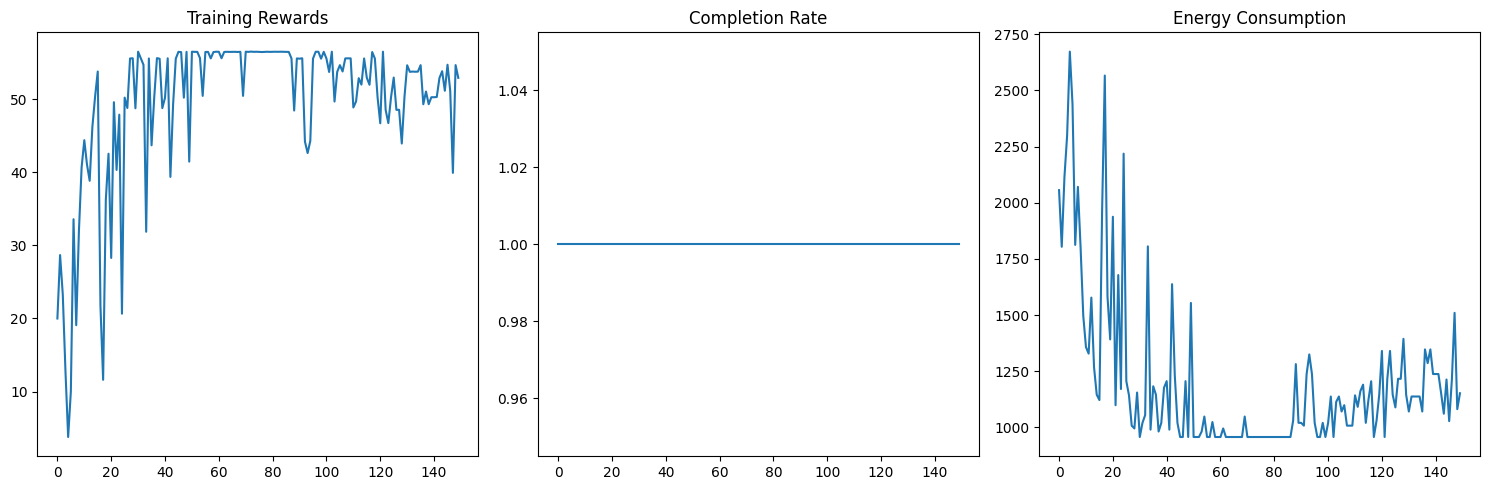